## Header

In [1]:
from __future__ import division
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from lmfit import Model, conf_interval, ci_report
from cells_11SL import intensity_ambmcpSL, set_standard_constraintsSL, setfix, calc_eta, get_cell_1RSL
from cells_11SL import set_rotation_domains,orthorhombic_only
from pprint import pprint
%matplotlib nbagg

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Fixed values

In [2]:
# 'In-plane' for a-a+c-. Determine this from measuring (1 1/2 3/2), (1/2 1 3/2), and (1/2 3/2 1) or similar.
# For in plane: D_2Rpmp -> D_2Lpmp,  D_1Lppm -> D_1Rpmp,  D_1Rpmp -> D_1Lpmp, D_2Lppm -> D_2Rppm
# Other 4 domains same as out-of-plane

# Set values for lattice, including symbols for the elements for the form factors. Also must indicate rotation type.
#Meas_Ints = np.array((41,3.1,155.5,33.4,346, 10.9, 4.3, 19.1)) # Measured intensity data

Rotations = 'Out-of-plane'
#Rotations = 'In-plane'
constants = OrderedDict([('a',3.905), ('b',3.905), ('c',3.95337), ('symbols',np.array(['Sr2+','Ti4+','Ti4+','O2-'])),
                         ('wavelength',0.775), ('I0',1),('Rot_type',np.array([Rotations]))])

## Setup model

In [3]:
# For fitting, takes the intensity function, and H,K,L, and eta as the independent variables, along with the constants.
May_model = Model(intensity_ambmcpSL, independent_vars=['H', 'K', 'L', 'eta'] + constants.keys())
params = May_model.make_params()

# Setup initial guesses

In [14]:
# Input guesses for the rotation angles, A-site displacements, and the volume fractions.
#D_2Rpmp -> D_2Lpmp,  D_1Lppm -> D_1Rppm,  D_1Rpmp -> D_1Lpmp, D_2Lppm ->D_2Rppm 

"""
# Below for In-plane
guesses = OrderedDict([('alpha1', 2.), ('beta1', 2.), ('gamma1',4.),('alpha2', 0.5), ('beta2', 0.5), ('gamma2', 1.)
                    , ('d1', 0.005), ('d2', 0.0199),
                     ('D_1Rppp',1.), ('D_2Rpmp',0.), ('D_1Lppm',0.), ('D_2Rmpp',0.), 
                     ('D_2Rppp',1.), ('D_1Rpmp',0.), ('D_2Lppm',1.), ('D_1Rmpp',1.),
                     ('D_2Lpmp',1.), ('D_1Rppm',1.), ('D_1Lpmp',1.), ('D_2Rppm',1.)  
                     ])


"""
# Below for out of plane
guesses = OrderedDict([('alpha1', 2.), ('beta1', 2.), ('gamma1',4.),('alpha2', 1.), ('beta2', 1.), ('gamma2', -2.)
                    , ('d1', 0.01), ('d2', 0.00),
                     ('D_1Rppp',1.), ('D_2Rpmp',1.), ('D_1Lppm',1.), ('D_2Rmpp',1.), 
                     ('D_2Rppp',1.), ('D_1Rpmp',1.), ('D_2Lppm',1.), ('D_1Rmpp',1.),
                     ('D_2Lpmp',0.), ('D_1Rppm',0.), ('D_1Lpmp',0.), ('D_2Rppm',0.)  
                     ])

                

## Get I0 using guesses and constants

In [21]:
# Combine guesses (fit parameters) and constants for I0 calcualtion
values = OrderedDict(guesses.items() + constants.items())
values['I0'] = 1.

# Get I0 using guesses and constants
HH = np.array([0.])
KK = np.array([0.])
LL = np.array([4.])
eta2 = calc_eta(24.125, 90)

# Set I0 as the ratio of measured intensity to the calculated itensity assuming I0 of 1.
# This is then used to normalize the rest of the peaks.
#I0_cps = 560000
I0_cps = 21.274*10000




SF = intensity_ambmcpSL(HH, KK, LL, eta2, *values.values())
values['I0'] = I0_cps/SF[0]
constants['I0'] = I0_cps/SF[0]
constants['I0']

0.096596105509787783

## Define Q vectors used

In [22]:
#             A-sites                              Gamma                                                                  Alpha
H = np.array(( 1. , 1. , 1. , 2. , 0.5, 1.5, 2.5,   0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 2.5,   0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5,))
K = np.array(( 1. , 1. , 1. , 2. , 0.5, 1.5, 2.5,   1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 2.5, 3.5, 3.5, 2.5, 2.5, 2.5, 1.5,   0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5,))
L = np.array(( 1.5, 2.5, 3.5, 2.5, 0.5, 1.5, 2.5,   1.5, 2.0, 2.5, 3.0, 2.5, 3.0, 3.5, 2.0, 3.5, 3.0, 2.5, 3.0, 3.5, 2.5,   1.5, 2.0, 2.5, 3.0, 2.5, 2.5, 3.0, 3.5, 2.0, 1.5, 3.5,))
#eta=np.array((  ))
#eta = np.ones(H.shape)*90. # for example data, eta is incidence angle for footprint

# Intensity values from experiment, not exact match for our guesses
#MayInts = np.array([5150, 1260,43000,1520,2980,175, 68.1]) 


## Get eta

In [23]:
# will be used in lieu of above cell with data from spec at experiment

import PyMca5.PyMcaCore.SpecFileDataSource as SFDS

# Load spec file
#         A-sites                           Gamma                                                                      Alpha     
idList = [77, 84, 90, 101, 240, 264,  257,    128, 129, 130, 131, 137, 138, 139, 140, 148, 149, 155, 156, 168, 174,   180, 181, 187, 188, 194, 205, 206, 212, 213, 219, 225]
pos =    [40, 36, 30,  37,  30,  80,   64,     40,  38,  33,  32,  33,  34,  29,  39,  28,  35,  35,  33,  27,  37,    40,  42,  36,  37,  27,  38,  44,  36,  42,  37,  33] 
chi = np.zeros(np.shape(H))
theta = np.zeros(np.shape(H))
Meas_Ints = np.zeros(np.shape(H))
spec_file = SFDS.SpecFileDataSource('/Users/derekmeyers/Dropbox/APS_Feb2017/ID33BM_Feb2017/SL_11_rerun_1.spec')
for i in enumerate(idList):
    scan = spec_file.getDataObject('{}.1'.format(i[1]))
    rixs = scan.getData()
    chi[i[0]] = rixs[pos[i[0]]-1,5]
    theta[i[0]] = rixs[pos[i[0]]-1,4]
    Meas_Ints[i[0]] = rixs[pos[i[0]]-1,16]


eta = calc_eta(theta, chi)

Meas_Ints*=10000
eta

# Remove A-site peaks which dont make sense. Something is obviously quite off.

H=H[7:]
K=K[7:]
L=L[7:]
eta=eta[7:]
Meas_Ints=Meas_Ints[7:]


Q = np.column_stack((H,K,L,eta))
print(Q)

[[  0.5          1.5          1.5          6.6239992 ]
 [  0.5          1.5          2.           9.64436392]
 [  0.5          1.5          2.5         12.75469652]
 [  0.5          1.5          3.          15.97680846]
 [  0.5          2.5          2.5          9.21618858]
 [  0.5          2.5          3.          12.38416458]
 [  0.5          2.5          3.5         15.6486284 ]
 [  0.5          2.5          2.           6.40352976]
 [  0.5          3.5          3.5         14.18861793]
 [  0.5          3.5          3.          11.19734609]
 [  1.5          2.5          2.5         13.98772552]
 [  1.5          2.5          3.          17.02654552]
 [  1.5          2.5          3.5         20.06170323]
 [  2.5          1.5          2.5         10.85741561]
 [  0.5          0.5          1.5         11.68485339]
 [  0.5          0.5          2.          14.18807835]
 [  0.5          0.5          2.5         16.75494325]
 [  0.5          0.5          3.          19.55135222]
 [  0.5   

## Run example with guesses.

<IPython.core.display.Javascript object>


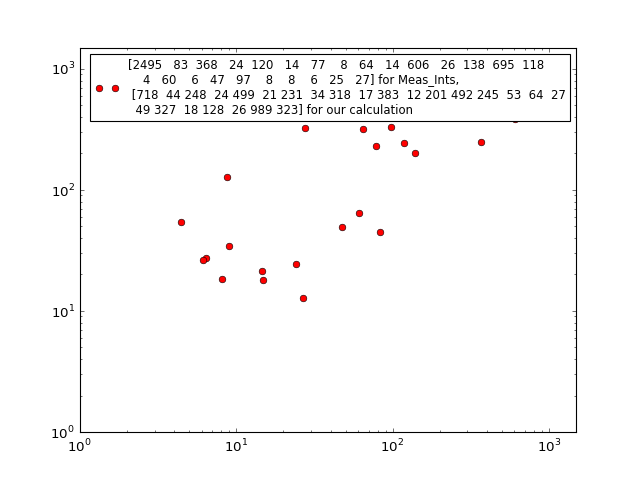

The error of the guesses is 404.19%
Weighted error: 99.12%
[[  0.5          1.5          1.5          6.6239992 ]
 [  0.5          1.5          2.           9.64436392]
 [  0.5          1.5          2.5         12.75469652]
 [  0.5          1.5          3.          15.97680846]
 [  0.5          2.5          2.5          9.21618858]
 [  0.5          2.5          3.          12.38416458]
 [  0.5          2.5          3.5         15.6486284 ]
 [  0.5          2.5          2.           6.40352976]
 [  0.5          3.5          3.5         14.18861793]
 [  0.5          3.5          3.          11.19734609]
 [  1.5          2.5          2.5         13.98772552]
 [  1.5          2.5          3.          17.02654552]
 [  1.5          2.5          3.5         20.06170323]
 [  2.5          1.5          2.5         10.85741561]
 [  0.5          0.5          1.5         11.68485339]
 [  0.5          0.5          2.          14.18807835]
 [  0.5          0.5          2.5         16.75494325]
 [  0.

In [24]:
# Calculate the intensities using guesses and constants and the calculated I0
I = intensity_ambmcpSL(H, K, L, eta, *values.values())
plt.plot(Meas_Ints, I, 'ro', label = '{} for Meas_Ints,\n {} for our calculation'.format(Meas_Ints.astype(int),I.astype(int)))
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 10.5)
plt.ylim(1,np.max(I)*1.5)
plt.xlim(1,np.max(I)*1.5)
PercentError = np.array(np.abs((I-Meas_Ints)/Meas_Ints)*100)
print('The error of the guesses is {:.2f}%'.format(np.average(PercentError)))
print('Weighted error: {:.2f}%'.format(np.average(np.sum(PercentError*Meas_Ints)/np.sum(Meas_Ints))))
print(Q)
print('{} Q-points'.format(len(Q)))

## Setup fit

In [19]:
#Fitting setup
ifix = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1]

# Setup parameters for fit. Also add additional constraints if needed
params = setfix(params,ifix)
params = set_standard_constraintsSL(May_model.make_params(**guesses))
params = set_rotation_domains(params, Rotations)
#Optional additional constraits
#params['d1'].set(expr = 'd2')
params['d2'].set(min=0.00,max = 0.05)
params['d1'].set(min=0.00,max = 0.05)
params['d2'].value = 0.0
params['d1'].value = 0.01


params['alpha1'].set(min=0.,max=12.)
params['gamma1'].set(min=0.,max=20.)
#params['gamma2'].value = 2.5
params['alpha2'].set(min=0,max=5)
params['gamma2'].set(min=-10,max=0)
#params['alpha2'].set(expr= 'alpha1')
#('alpha1', 2.), ('beta1', 2.), ('gamma1', 1.7),('alpha2', 0.), ('beta2', 0.), ('gamma2', 0.)
#                    , ('d1', 0.003), ('d2', 0.003),
#params['alpha1'].set(expr = 'alpha2')
#params['gamma1'].set(expr = 'gamma2')
# If orthohombic only. Otherwise will include monoclinic domains as well.
#params = orthorhombic_only(params,Rotations)



## Run iterative fit

In [25]:
# Begins with guess values then updates to the results of previous. 4 iterations needed to converge to lowest error.
weights = 2./Meas_Ints

weights[weights < 1] = 1

for i in range(3):
    if i != 0:
        guesses.update(result.best_values)
    values = OrderedDict(guesses.items() + constants.items())

    # Get new I0 using fit parameters and constants
    values['I0']=1
    SF_004 = intensity_ambmcpSL(HH, KK, LL, eta2, *values.values())
    constants['I0'] = I0_cps/SF_004[0]

    # Setup parameters for fit. Also add additional constraints if needed
    params = setfix(params,ifix)
    # Run Fit 
    result = May_model.fit(Meas_Ints, H=H, K=K, L=L, eta=eta, params=params,  **constants)#, weights = weights, method = 'differential_evolution')
    #print(result.message)

# Display fitting results and errors
print(result.fit_report())
Ints = result.best_fit

PercentError = np.array(np.abs((Ints-Meas_Ints)/Meas_Ints)*100)
print('Intensity errors are an average of {:.2f}%'.format(np.average(PercentError)))
print('List intensity errors to check for bad peaks: {}'.format(PercentError.astype('int')))
print('Weighted error: {}%'.format(np.average(np.sum(PercentError*Meas_Ints)/np.sum(Meas_Ints))))
print(' Weights : {}'.format(weights))

[[Model]]
    Model(intensity_ambmcpSL)
[[Fit Statistics]]
    # function evals   = 3769
    # data points      = 25
    # variables        = 6
    chi-square         = 4605374.882
    reduced chi-square = 242388.152
    Akaike info crit   = 315.096
    Bayesian info crit = 322.410
[[Variables]]
    alpha1:    0.94537109 +/- 0        (0.00%) (init= 2)
    beta1:     0.94537109 +/- 0        (0.00%)  == 'alpha1'
    gamma1:    0          +/- 0        (nan%) (init= 4)
    alpha2:    4.9436e-05 +/- 0        (0.00%) (init= 1)
    beta2:     4.9436e-05 +/- 0        (0.00%)  == 'alpha2'
    gamma2:   -1.3440e-09 +/- 0        (0.00%) (init=-2)
    d1:        0.00048825 +/- 0        (0.00%) (init= 0.01)
    d2:        0.00304813 +/- 0        (0.00%) (init= 0.01)
    D_1Rppp:   1 (fixed)
    D_2Rpmp:   1 (fixed)
    D_1Lppm:   1 (fixed)
    D_2Rmpp:   1 (fixed)
    D_2Rppp:   1 (fixed)
    D_1Rpmp:   1 (fixed)
    D_2Lppm:   1 (fixed)
    D_1Rmpp:   1 (fixed)
    D_2Lpmp:   0 (fixed)
    D_1Rppm

In [11]:
Meas_Ints.astype('int')

array([2495,   83,  368,   24,  120,   14,   77,    8,   64,   14,  606,
         26,  138,  695,  118,    4,   60,    6,   47,   97,    8,    8,
          6,   25,   27])

In [12]:
Ints.astype('int')

array([718,  44, 248,  24, 499,  21, 231,  34, 318,  17, 383,  12, 201,
       492, 245,  53,  64,  27,  49, 327,  18, 128,  26, 989, 323])

In [13]:
H = np.array(0)
K = np.array(0)
L = np.array(4)
eta = calc_eta(24.125,90)
print('{} {} {}'.format(H,K,L))
print(intensity_ambmcpSL(H, K, L, 20.5, *values.values()))

0 0 4
2570392.22035


In [ ]:
# Currently cannot converge on good result. The biggest issue is the contrast of B-sites for n n n/2 peaks gives 
# huge contribution, so cannot get d1, d2, which also contribute to rotation / tilt peaks. It is possible B-sites
# also have some displacements, which could then also cause contributions.
